In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pickle
import re
from dime_take_home.utils import get_locations_from_text

2025-09-14 15:01:31.859 | INFO     | dime_take_home.config:<module>:11 - PROJ_ROOT path is: /Users/alexisrutherford/dime_take_home


## Take a quick look at some [HDX food insecurity data on Syria](https://data.humdata.org/dataset/syrian-arab-republic-food-security-agriculture-severity-classification#)

In [8]:
df = pd.read_excel('../data/external/syr-food-sector-pin_severity_2024.xlsx', sheet_name='Food_PiN_by_severity_HNO_2024', header=1)

In [9]:
df.head()

,#adm1 +name,#adm1 +code,#adm2 +name,#adm2 +code,#adm3 +name,#adm3 +code,#Indicator +num,#inneed +ind
0,Damascus,SY01,Damascus,SY0100,Damascus,SY010000,3,898967.999742
1,Aleppo,SY02,Ain Al Arab,SY0206,Lower Shyookh,SY020601,3,12597.570000
2,Aleppo,SY02,Al Bab,SY0202,Dayr Hafir,SY020202,3,20229.982609
3,Aleppo,SY02,Ain Al Arab,SY0206,Ain al Arab,SY020600,3,60936.990000
4,Aleppo,SY02,A'zaz,SY0204,Tall Refaat,SY020402,3,4928.040000


In [10]:
with open("../data/processed/en_locations_reversed.pkl", "rb") as f:
    locations_dict_en_reversed = pickle.load(f)

In [13]:
locations_pattern_en = re.compile(r"\b(?:%s)\b" % "|".join(map(re.escape, locations_dict_en_reversed.keys())),re.IGNORECASE)


In [21]:
get_locations_from_text('al bab',locations_lookup=locations_dict_en_reversed, locations_pattern=locations_pattern_en)

['sy_hl_3']

# Try [Palestine Food Insecurity Index](https://data.humdata.org/dataset/state-of-palestine-acute-food-insecurity-country-data#)

In [21]:
df = pd.read_csv('../data/external/ipc_pse_area_long.csv',header=0)

In [22]:
df.head()

,Date of analysis,Country,Total country population,Level 1,Area,Validity period,From,To,Phase,Number,Percentage
0,#date+analysis,#country+code,#population,#loc+level1,#loc+area,#period+v_ipc,#date+start,#date+end,#severity+v_ipc,#affected+num,#affected+pct
1,Jul 2025,PSE,2100719,NaN,Deir al-Balah,current,2025-07-01,2025-08-31,all,482315,1.0
2,Jul 2025,PSE,2100719,NaN,Deir al-Balah,current,2025-07-01,2025-08-31,3+,482315,1
3,Jul 2025,PSE,2100719,NaN,Deir al-Balah,current,2025-07-01,2025-08-31,1,0,0
4,Jul 2025,PSE,2100719,NaN,Deir al-Balah,current,2025-07-01,2025-08-31,2,0,0


In [23]:
df = df.iloc[1:,:]
# Drop the extra header ro

In [24]:
df.groupby(['From','To']).size()

From        To        
2023-11-01  2023-12-31    21
2023-12-01  2024-02-29    21
2024-02-01  2024-03-31    21
2024-03-01  2024-07-31    21
2024-05-01  2024-06-30    21
2024-06-01  2024-09-30    21
2024-09-01  2024-10-31    21
2024-11-01  2025-04-30    21
2025-04-01  2025-05-31    35
2025-05-01  2025-09-30    35
2025-07-01  2025-08-31    21
2025-08-01  2025-09-30    21
dtype: int64

In [26]:
df = df[df['From'].isin(['2024-06-01','2024-07-01'])]

In [28]:
df.shape

(21, 11)

In [ ]:
df

,Date of analysis,Country,Total country population,Level 1,Area,Validity period,From,To,Phase,Number,Percentage
162,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,all,300000,1.0
163,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,3+,300000,1
164,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,1,0,0
165,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,2,0,0
166,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,3,75000,0.25
167,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,4,150000,0.5
168,May 2024,PSE,2251457,NaN,North Gaza,first projection,2024-06-01,2024-09-30,5,75000,0.25
176,May 2024,PSE,2251457,NaN,Rafah,first projection,2024-06-01,2024-09-30,all,200000,1.0
177,May 2024,PSE,2251457,NaN,Rafah,first projection,2024-06-01,2024-09-30,3+,190000,0.95
178,May 2024,PSE,2251457,NaN,Rafah,first projection,2024-06-01,2024-09-30,1,0,0


# Now try [WB FEWS data](https://datacatalog.worldbank.org/search/dataset/0064614/Harmonized-Sub-National-Food-Security-Data)

In [34]:
df = pd.read_csv('../data/external/FEWS_October_2024_Update_TrueBoundaries_12-09-24.csv')

In [37]:
df['country'].unique()

array(['Afghanistan', 'Burkina Faso', 'Burundi', 'Cameroon', 'Chad',
       'Democratic Republic of the Congo', 'Ethiopia', 'Guatemala',
       'Haiti', 'Kenya', 'Madagascar', 'Malawi', 'Mali', 'Mozambique',
       'Niger', 'Nigeria', 'Somalia', 'South Sudan', 'Sudan', 'Uganda',
       'Yemen', 'Zimbabwe', 'System.IO.MemoryStream'], dtype=object)

In [36]:
df[df['country']=='Syria']

,country,admin_code,year_month,year,month,fews_ipc,fews_ha,fews_proj_near,fews_proj_near_ha,fews_proj_med,fews_proj_med_ha,pop,pop_source,fews_ipc_adjusted,fews_proj_med_adjusted,admin_name


## Try [WB Monthly food price data](https://microdata.worldbank.org/index.php/catalog/4483/get-microdata)

In [13]:
df = pd.read_csv('../data/external/WLD_RTFP_mkt_2024-07-01.csv')

In [4]:
df.head()

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yogurt,c_yogurt,inflation_yogurt,trust_yogurt,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
0,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-01-01,2007,...,NaN,NaN,NaN,NaN,0.60,0.62,0.60,0.60,NaN,7.8
1,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-02-01,2007,...,NaN,NaN,NaN,NaN,0.61,0.62,0.60,0.61,NaN,7.8
2,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-03-01,2007,...,NaN,NaN,NaN,NaN,0.62,0.63,0.61,0.62,NaN,7.8
3,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-04-01,2007,...,NaN,NaN,NaN,NaN,0.62,0.65,0.61,0.65,NaN,7.8
4,AFG,Afghanistan,Badakhshan,Argo,Badakhshan,37.03785,70.45621,gid_370378500704562100,2007-05-01,2007,...,NaN,NaN,NaN,NaN,0.66,0.70,0.65,0.70,NaN,7.8


In [14]:
df = df[df['ISO3'].isin(['SYR','IRQ','LBN','PSE','JOR'])]

In [15]:
df = df[df['year'] == 2024]

In [16]:
df = df[df['DATES'].isin( ['2024-06-01','2024-07-01'])]

In [21]:
df.groupby('ISO3').size()

ISO3
IRQ     40
LBN     54
SYR    196
dtype: int64

In [22]:
df.head()

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yogurt,c_yogurt,inflation_yogurt,trust_yogurt,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
175676,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.13,1.14,1.11,1.11,2.82,10.0
175677,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.11,1.12,1.10,1.11,2.96,10.0
175827,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.18,1.19,1.16,1.16,-1.07,10.0
175828,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.16,1.17,1.13,1.13,-3.31,10.0
175978,IRQ,Iraq,Baghdad,Al-Resafa,Baghdad,33.338611,44.393889,gid_333386111443938889,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.42,1.43,1.41,1.41,-2.32,10.0


In [28]:
df.head()

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yogurt,c_yogurt,inflation_yogurt,trust_yogurt,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
175676,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.13,1.14,1.11,1.11,2.82,10.0
175677,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.11,1.12,1.10,1.11,2.96,10.0
175827,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.18,1.19,1.16,1.16,-1.07,10.0
175828,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.16,1.17,1.13,1.13,-3.31,10.0
175978,IRQ,Iraq,Baghdad,Al-Resafa,Baghdad,33.338611,44.393889,gid_333386111443938889,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.42,1.43,1.41,1.41,-2.32,10.0


In [41]:
df.shape

(290, 536)

In [40]:
df.isnull().sum().sort_values(ascending=False).head(300)

trust_sorghum_food_aid        290
inflation_sorghum_food_aid    290
c_sorghum_food_aid            290
l_sorghum_food_aid            290
h_sorghum_food_aid            290
                             ... 
cheese                        263
dates                         262
inflation_fish                250
c_fish                        250
o_fish                        250
Length: 300, dtype: int64

In [42]:
df = df.dropna(axis=1, how='all')
# Drop the null columns

In [43]:
df.shape

(290, 251)

In [46]:
df = df.loc[:, df.isnull().mean() < 0.8]
# Drop the 80% or more null columns

In [48]:
df.shape

(290, 184)

In [49]:
df.head()

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yogurt,c_yogurt,inflation_yogurt,trust_yogurt,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
175676,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.13,1.14,1.11,1.11,2.82,10.0
175677,IRQ,Iraq,Anbar,Ramadi,Anbar,33.416312,43.302097,gid_334163120433020970,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.11,1.12,1.10,1.11,2.96,10.0
175827,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.18,1.19,1.16,1.16,-1.07,10.0
175828,IRQ,Iraq,Babil,Al-Musayab,Babylon,32.483182,44.437380,gid_324831820444373800,2024-07-01,2024,...,NaN,NaN,NaN,NaN,1.16,1.17,1.13,1.13,-3.31,10.0
175978,IRQ,Iraq,Baghdad,Al-Resafa,Baghdad,33.338611,44.393889,gid_333386111443938889,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.42,1.43,1.41,1.41,-2.32,10.0


In [24]:
print(df.groupby(['ISO3','adm1_name','adm2_name']).size())

ISO3  adm1_name       adm2_name     
IRQ   Anbar           Ramadi             2
      Babil           Al-Musayab         2
      Baghdad         Al-Resafa          2
      Basrah          Basrah             2
      Dahuk           Dahuk              2
                                        ..
SYR   Rural Damascus  Rural Damascus    10
      Tartous         Banyas             2
                      Safita             4
                      Sheikh Badr        2
                      Tartous            2
Length: 97, dtype: int64


In [50]:
df.groupby(['ISO3','adm1_name']).size()

ISO3  adm1_name        
IRQ   Anbar                 2
      Babil                 2
      Baghdad               2
      Basrah                2
      Dahuk                 2
      Diyala                2
      Erbil                 2
      Kerbala               2
      Kirkuk                2
      Market Average        2
      Missan                2
      Muthanna              2
      Najaf                 2
      Ninewa                4
      Qadissiya             2
      Salah al-Din          2
      Sulaymaniyah          2
      Thi-Qar               2
      Wassit                2
LBN   Akkar                 2
      Baalbek-El Hermel     4
      Beirut                2
      Bekaa                 6
      El Nabatieh           8
      Market Average        2
      Mount Lebanon        12
      North                12
      South                 6
SYR   Al-Hasakeh            8
      Aleppo               26
      Ar-Raqqa             12
      As-Sweida             8
      Damascus  

In [60]:
min, max = df['inflation_food_price_index'].min(), df['inflation_food_price_index'].max()

In [66]:
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)

In [81]:
ylim_dict = {iso: [group['inflation_food_price_index'].min(), group['inflation_food_price_index'].max()] 
                for iso, group in df.groupby('ISO3')}
# Need different scales for each country

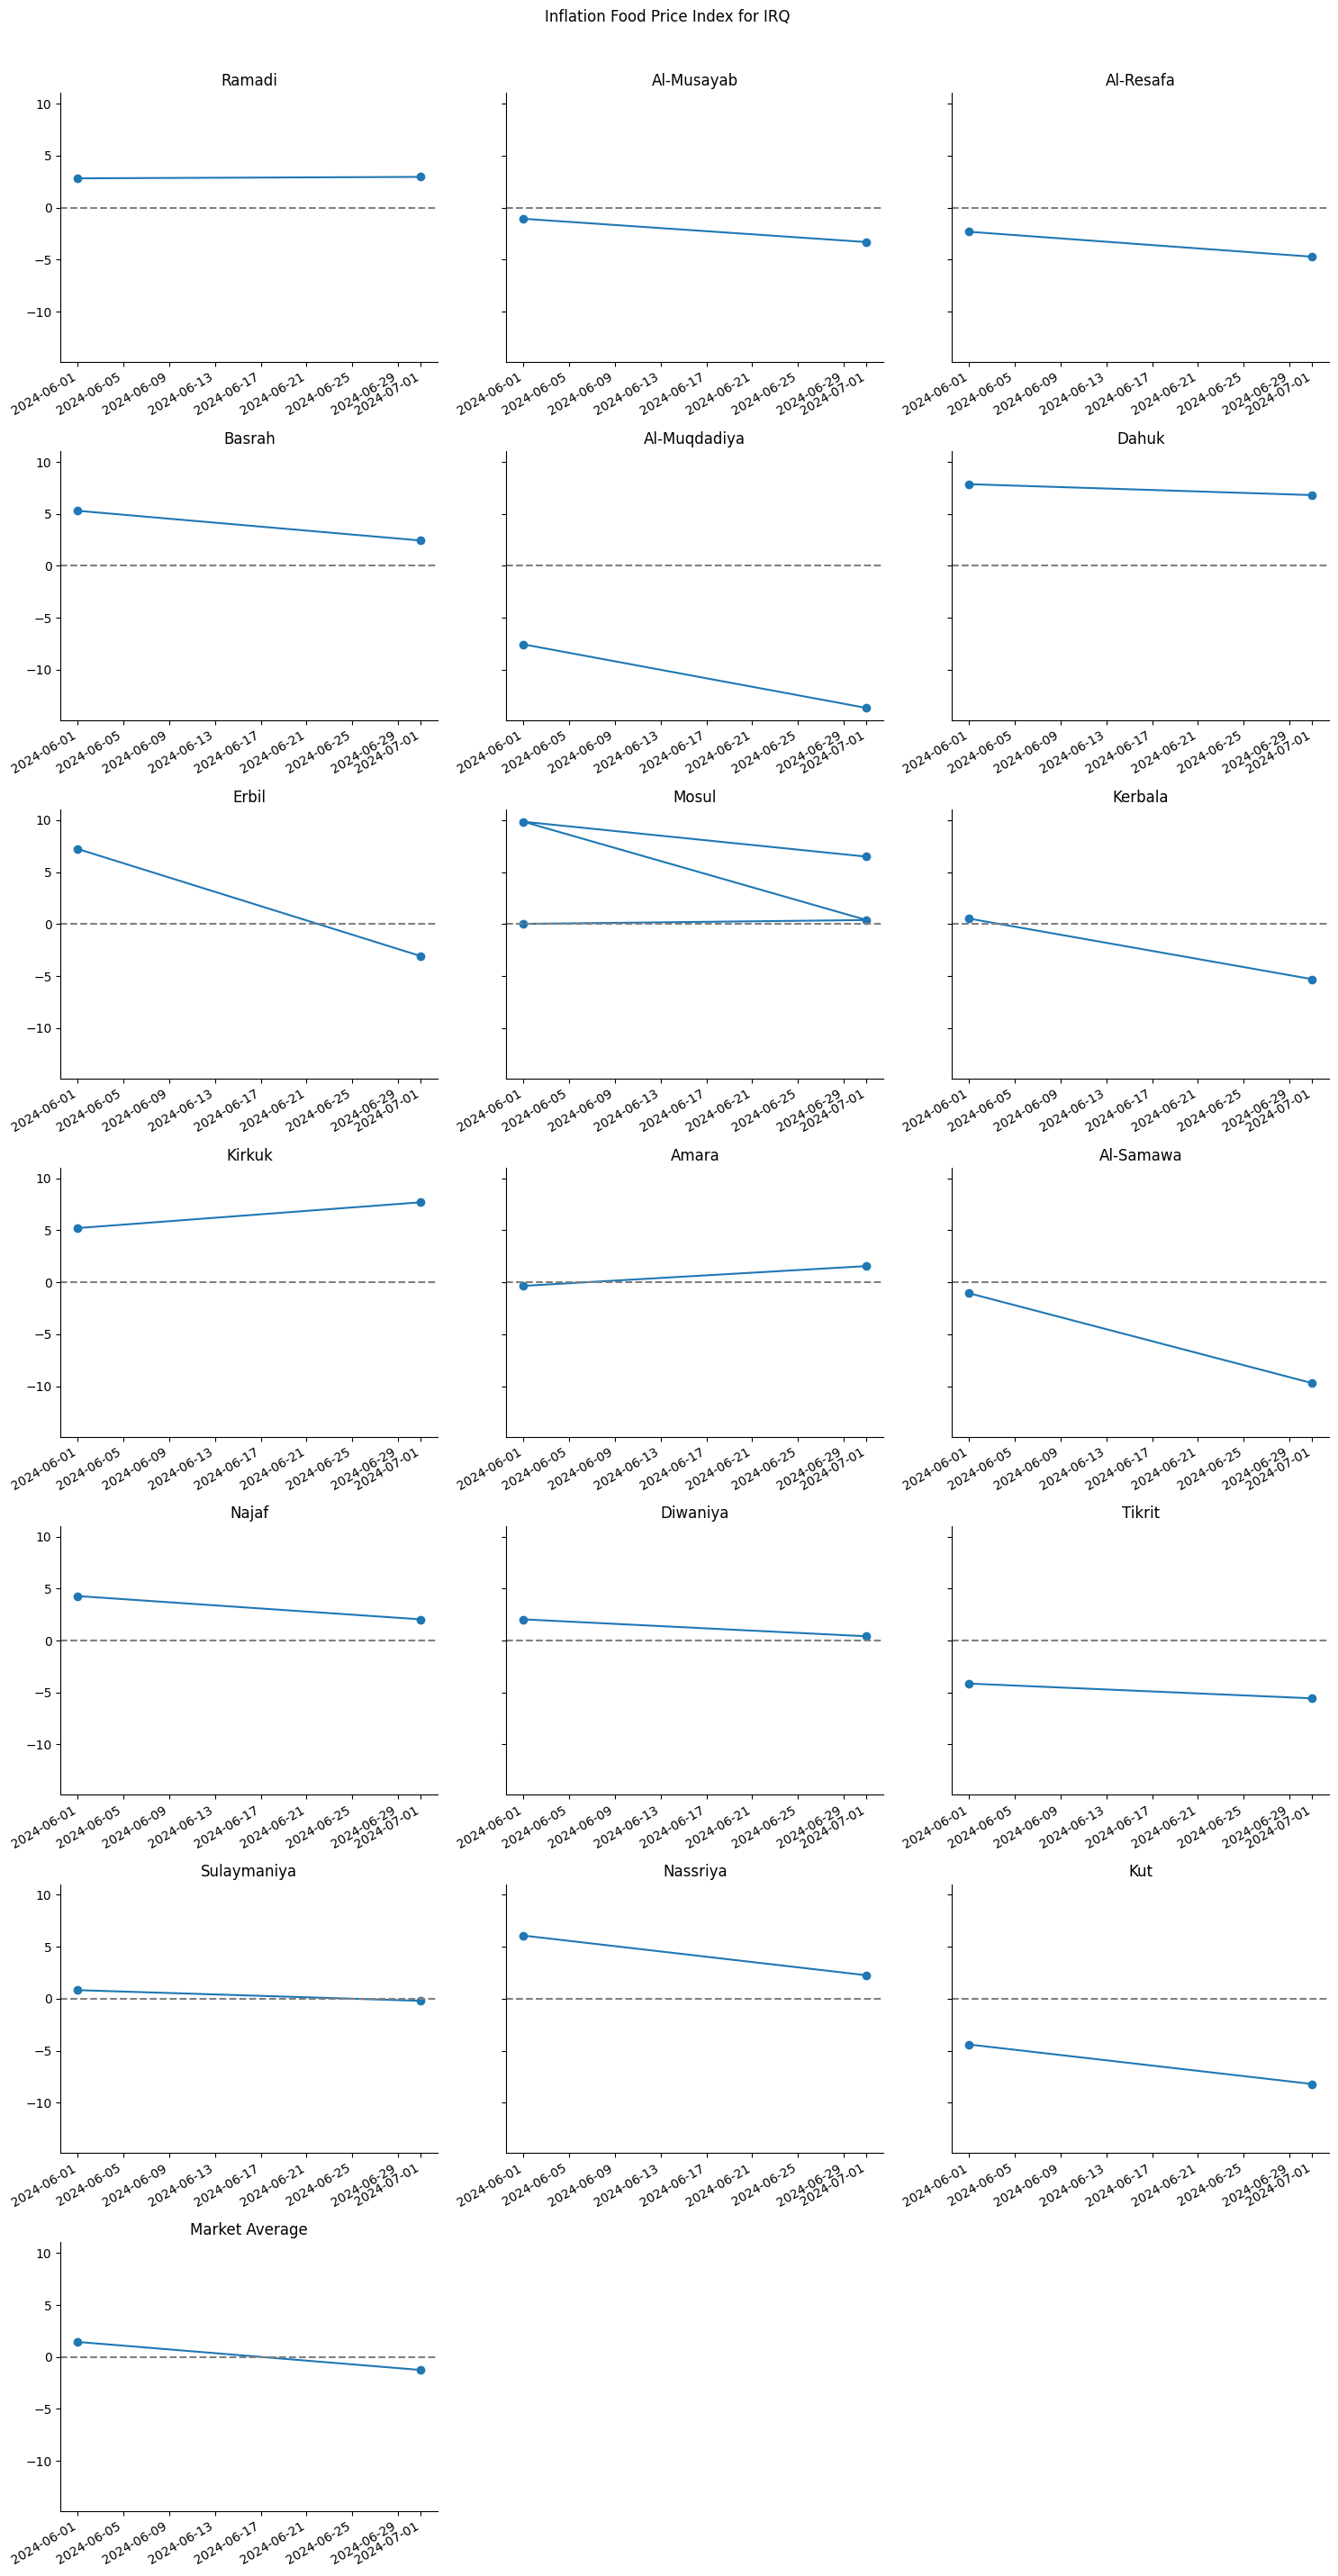

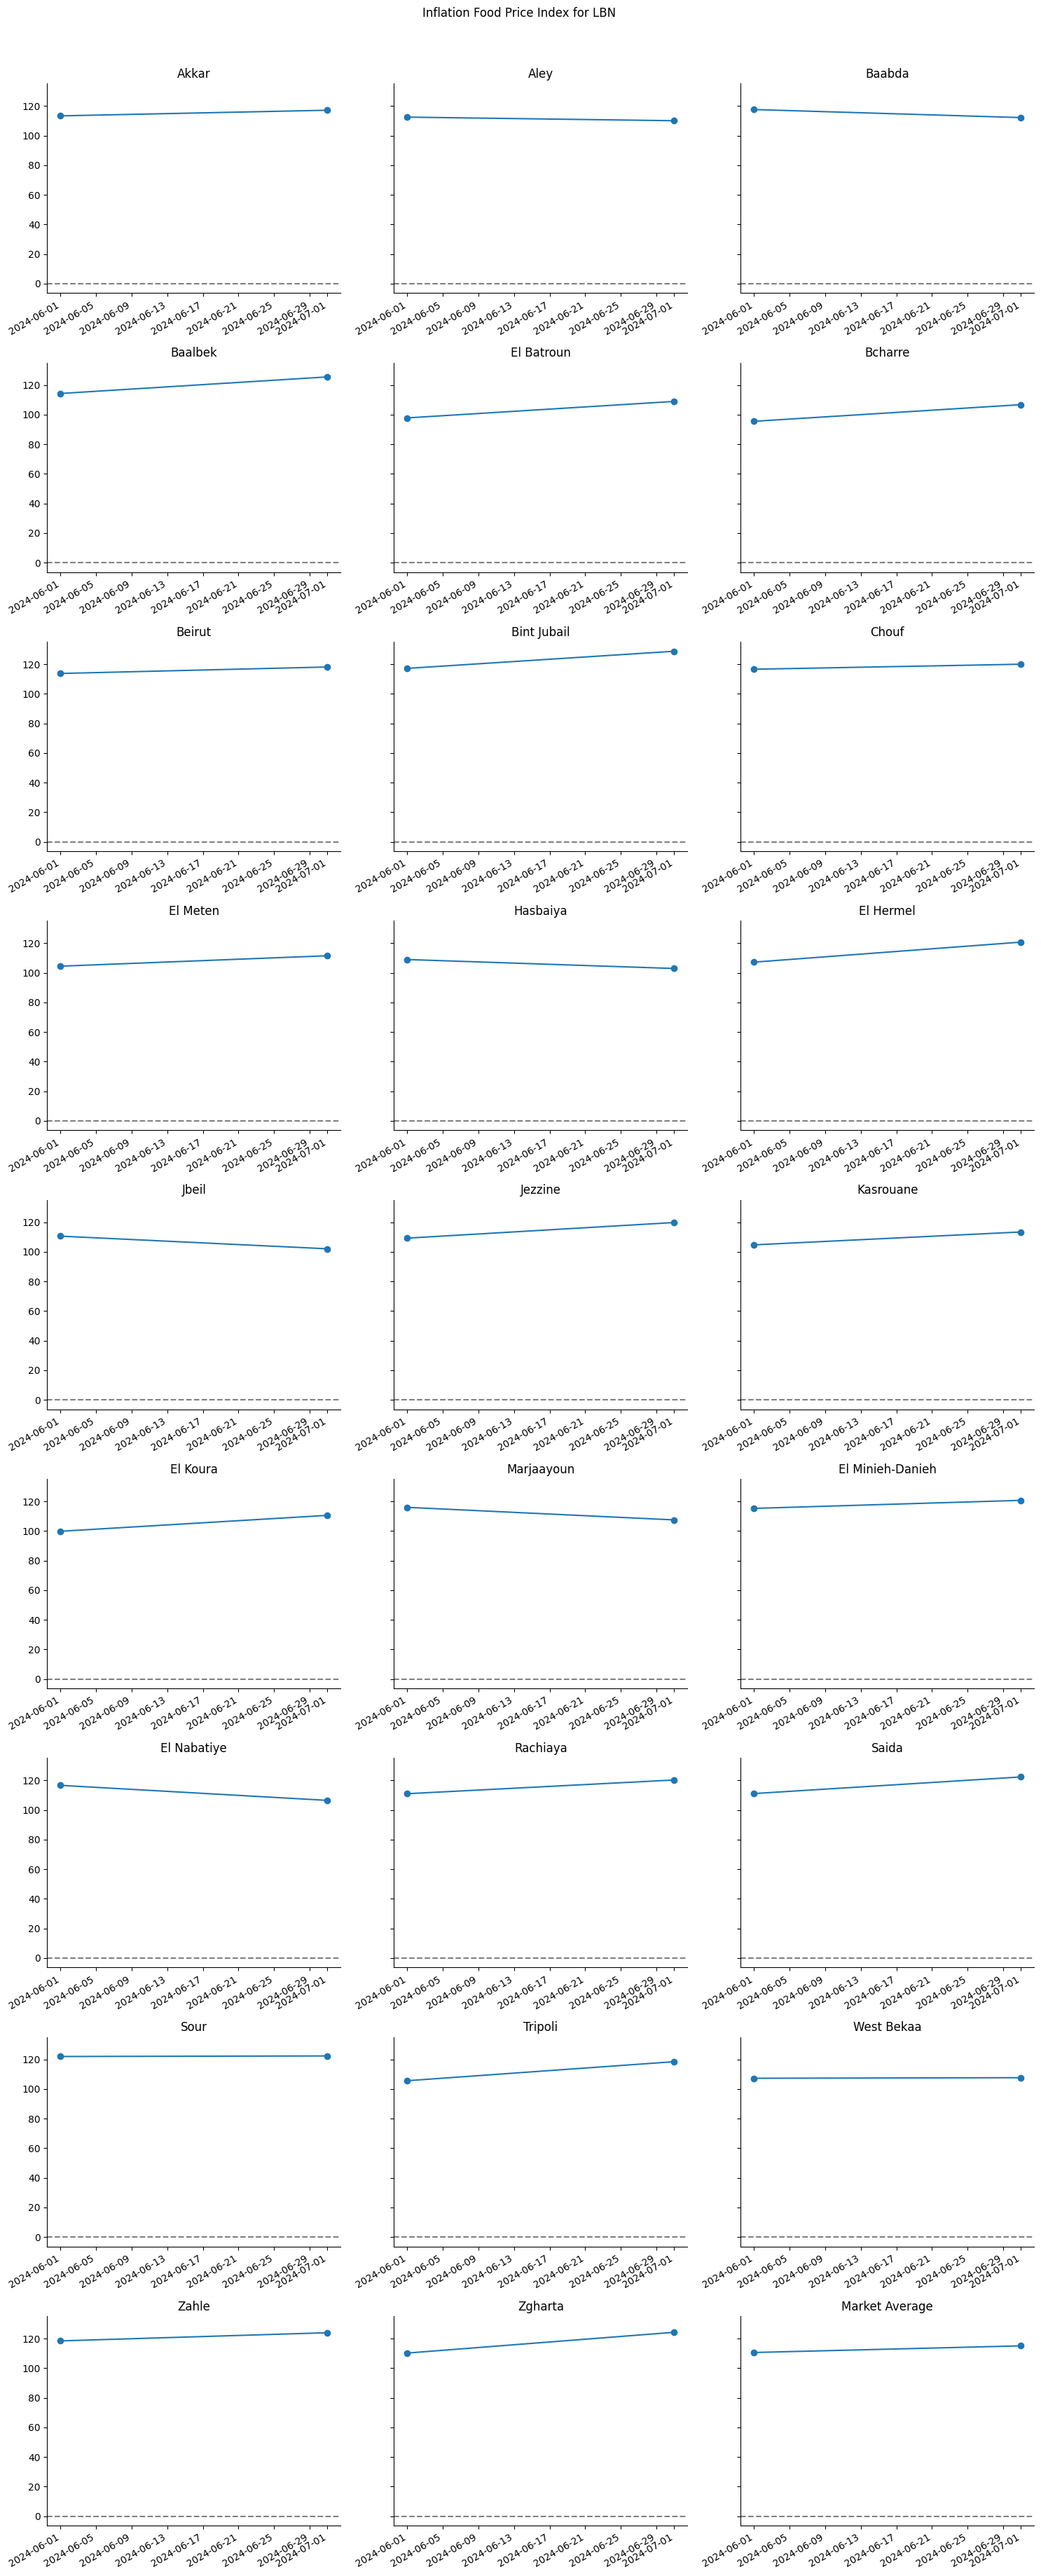

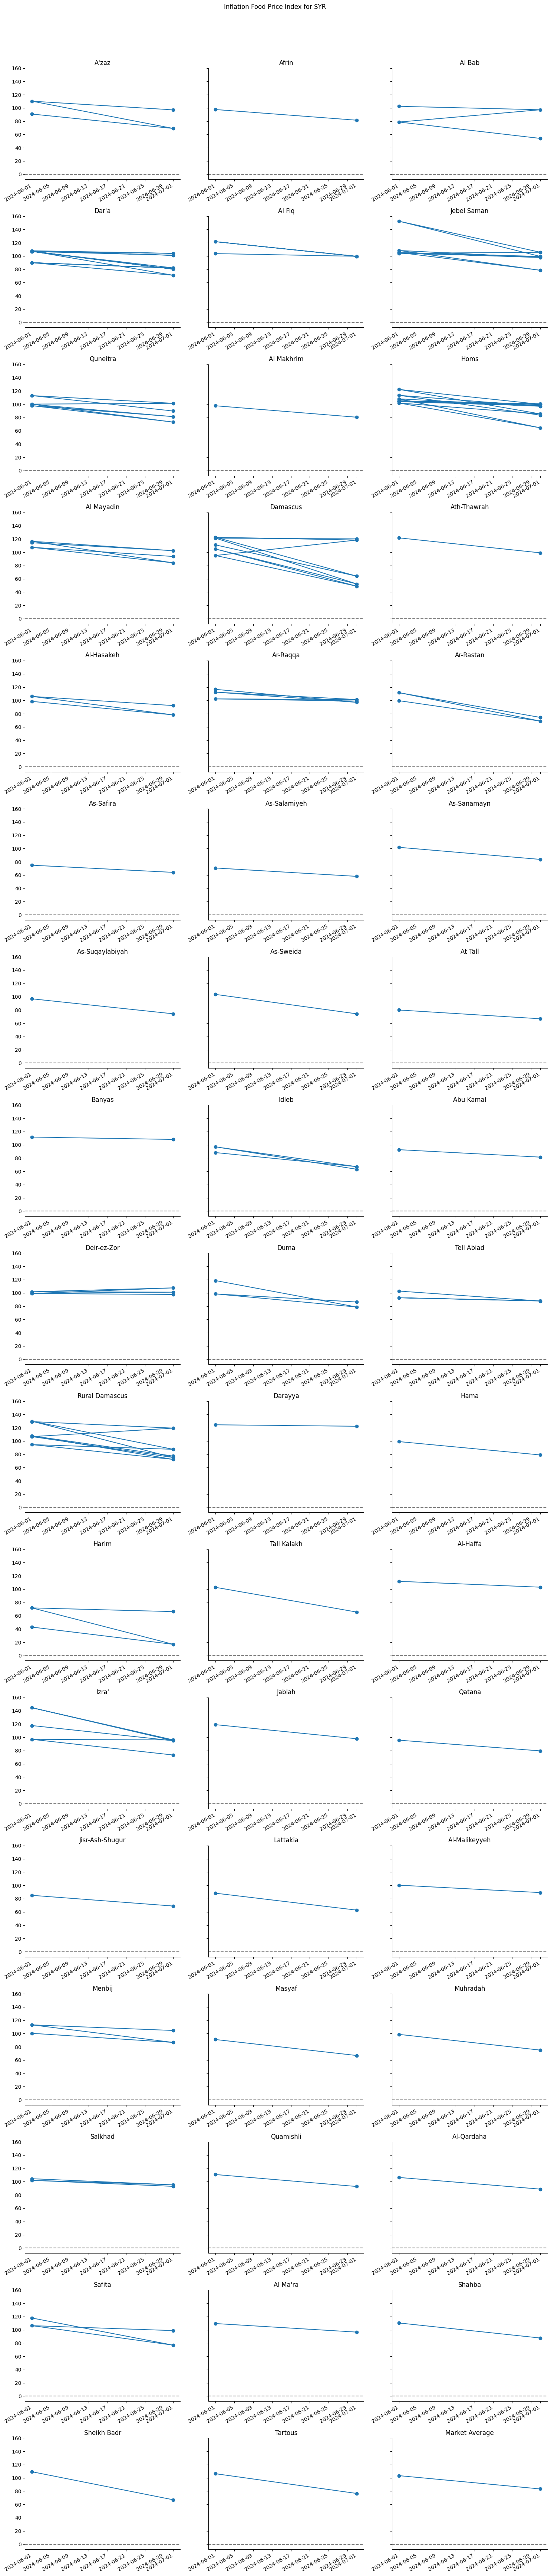

In [92]:
import matplotlib.pyplot as plt

for iso in df['ISO3'].unique():
    admin1_list = df[df['ISO3'] == iso]['adm2_name'].unique()
    n = len(admin1_list)
    ncols = 3  # adjust as needed
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharey=True)
    axes = axes.flatten()

    for ax, admin1 in zip(axes, admin1_list):
        group = df[(df['ISO3'] == iso) & (df['adm2_name'] == admin1)]
        group.plot(
            y='inflation_food_price_index',
            ax=ax,
            style='o-',
            title=f"{iso} - {admin1}",
            legend=False
        )
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0, linestyle='--', color='grey')
        ax.set_xlabel('')
        ax.set_title(admin1)

    # Hide unused axes
    for ax in axes[len(admin1_list):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.suptitle(f"Inflation Food Price Index for {iso}", y=1.02)
    plt.show()

In [95]:
df[df['adm2_name']=='Homs'].groupby('DATES')['inflation_food_price_index'].mean()

DATES
2024-06-01    107.92625
2024-07-01     90.88375
Name: inflation_food_price_index, dtype: float64

/Users/alexisrutherford/dime_take_home/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


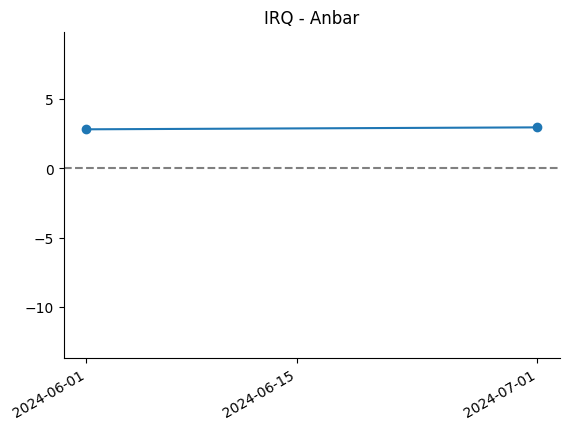

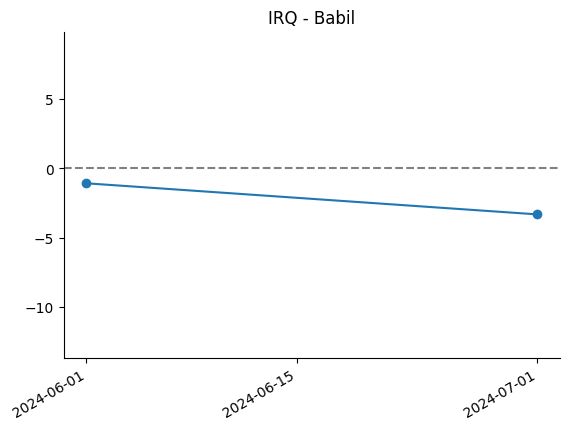

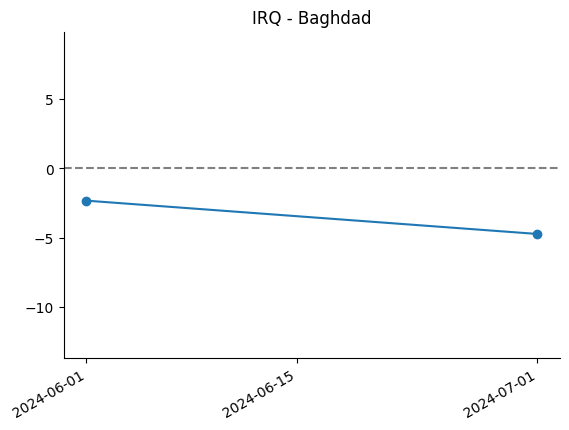

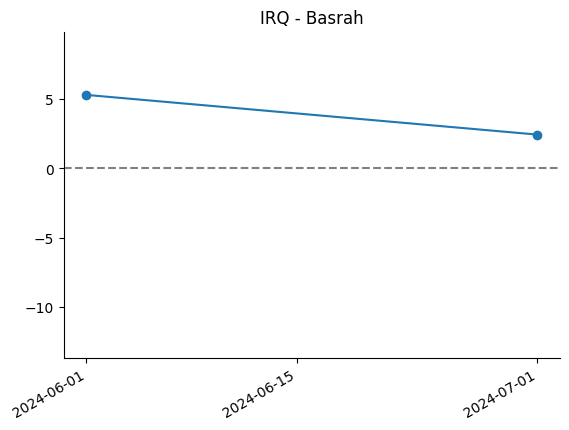

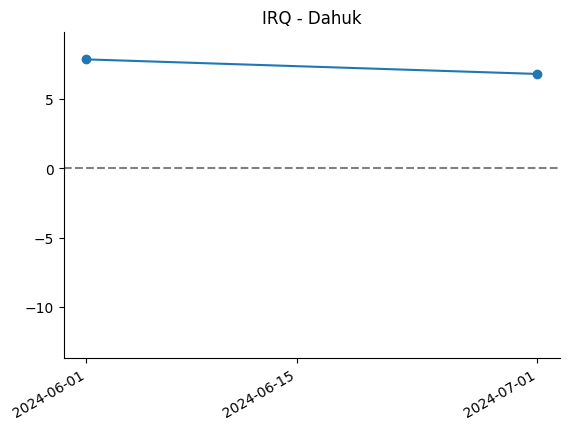

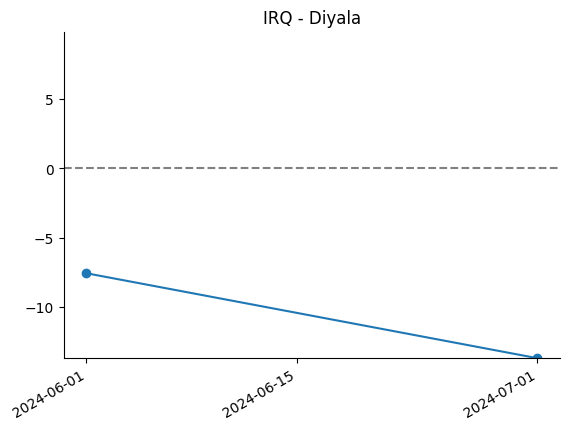

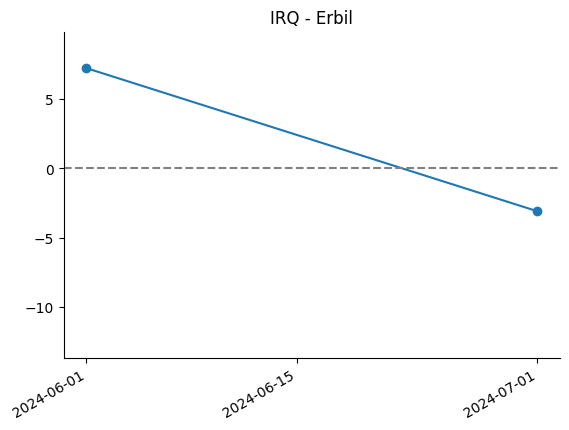

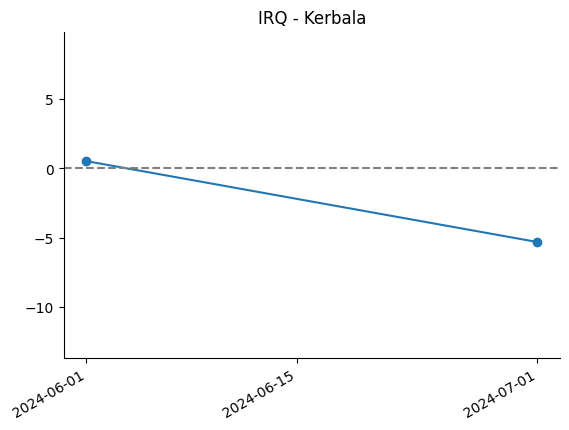

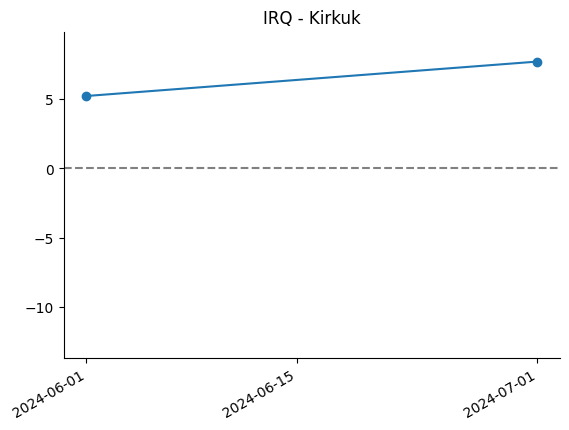

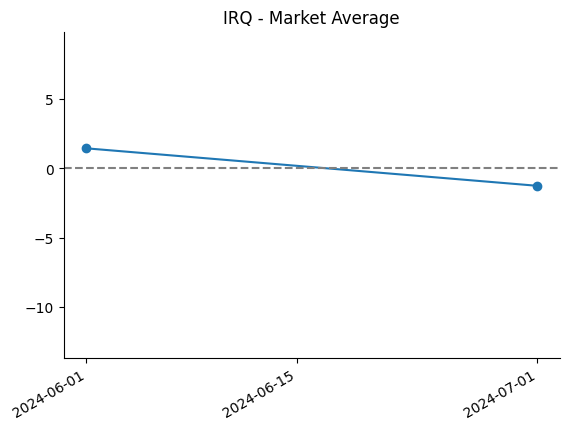

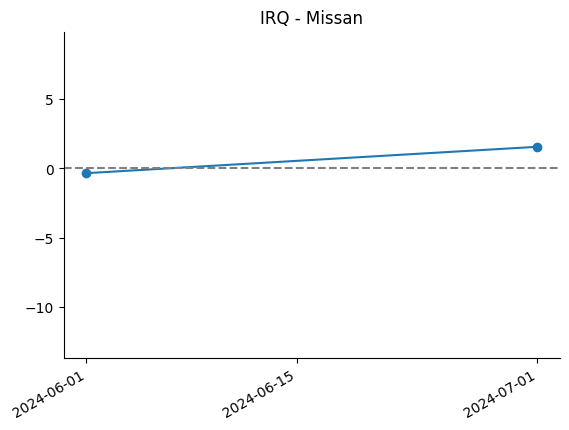

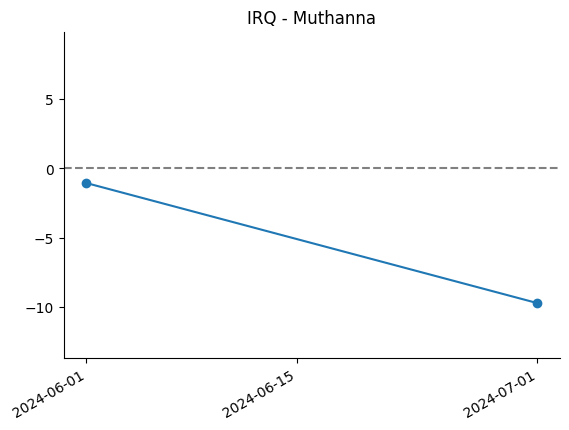

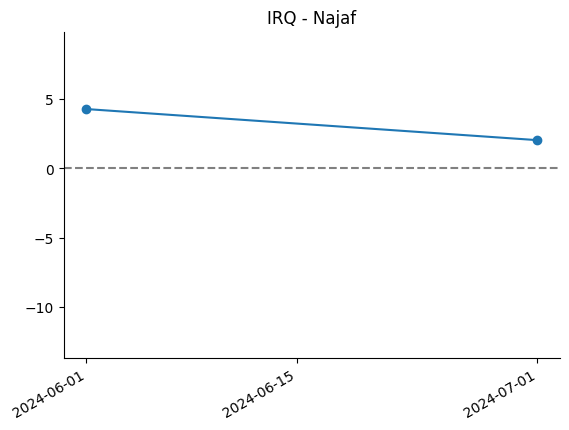

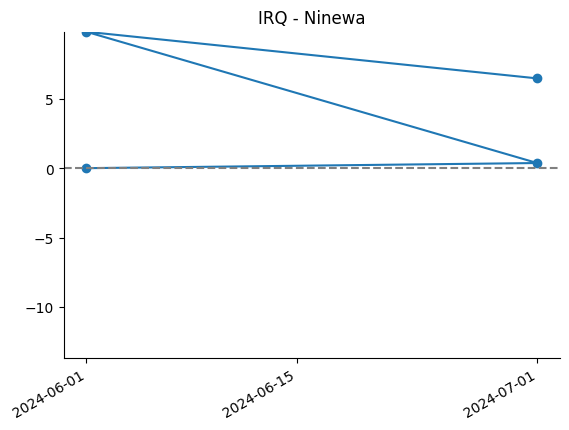

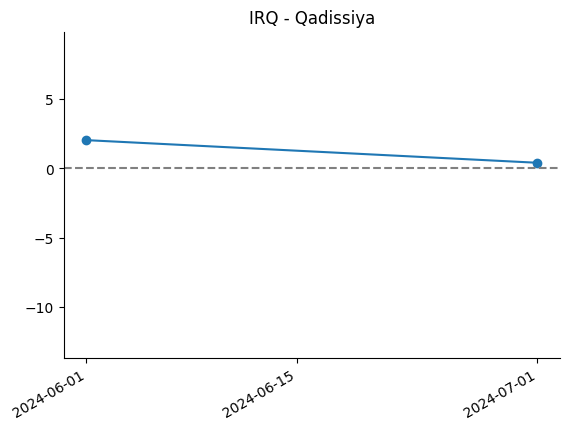

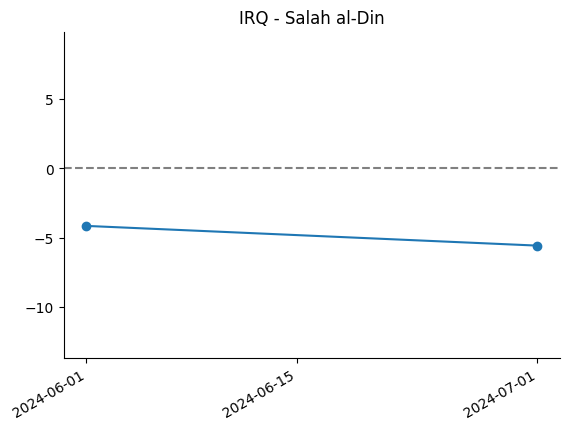

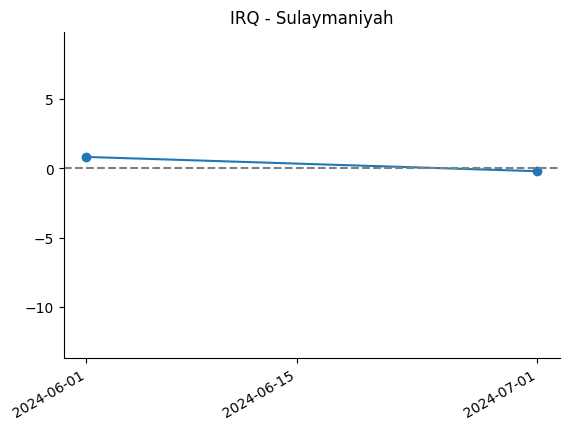

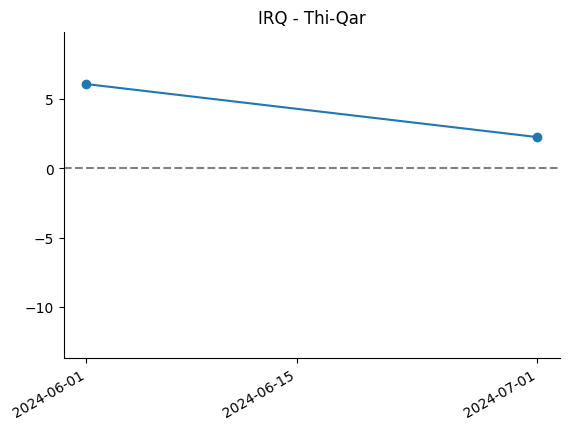

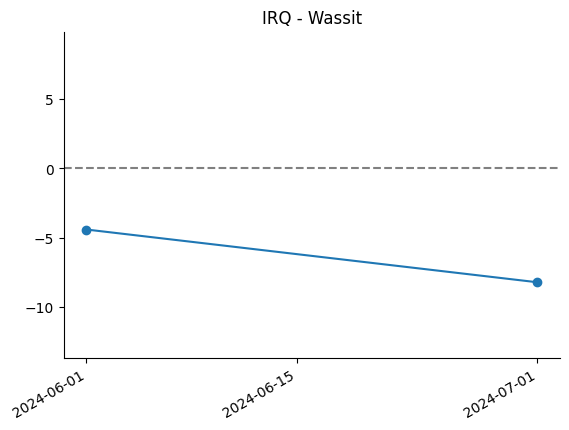

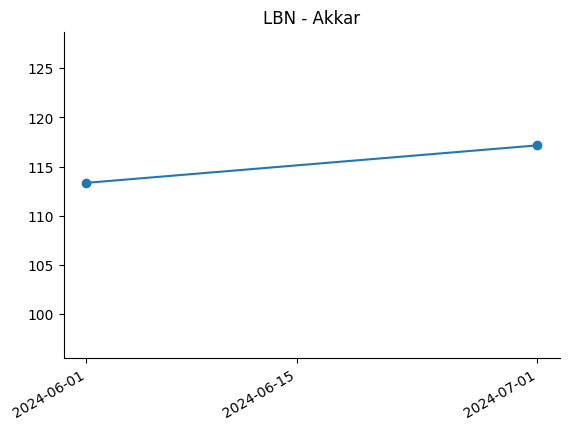

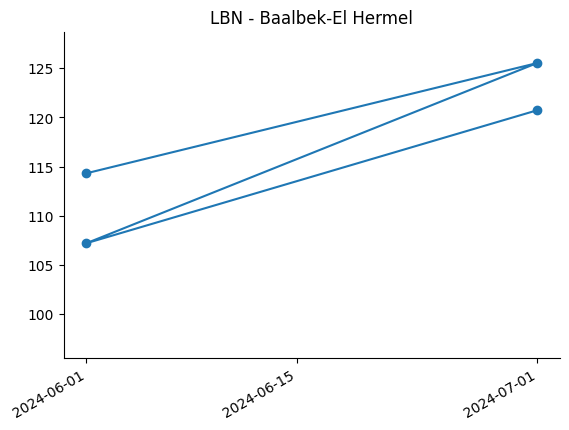

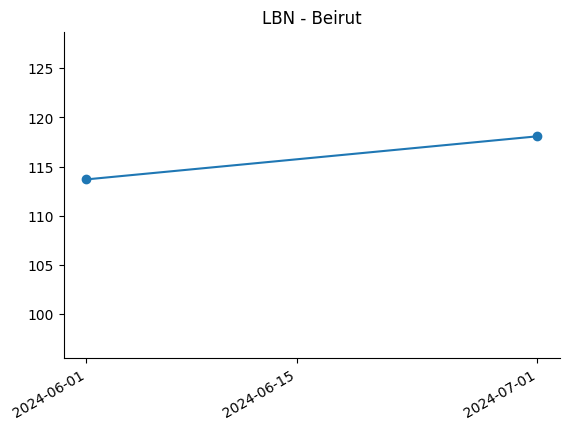

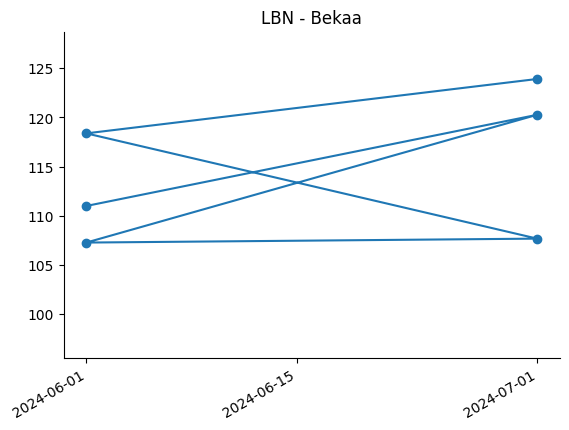

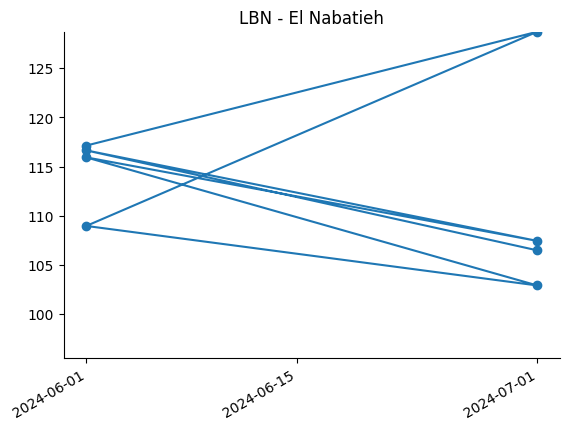

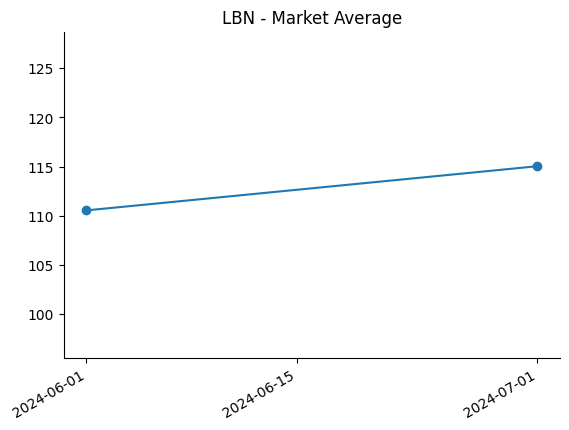

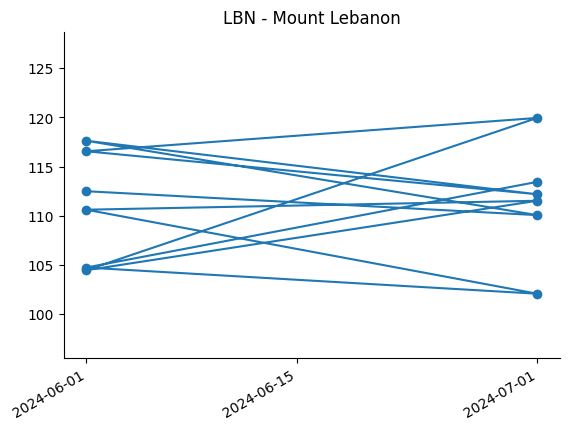

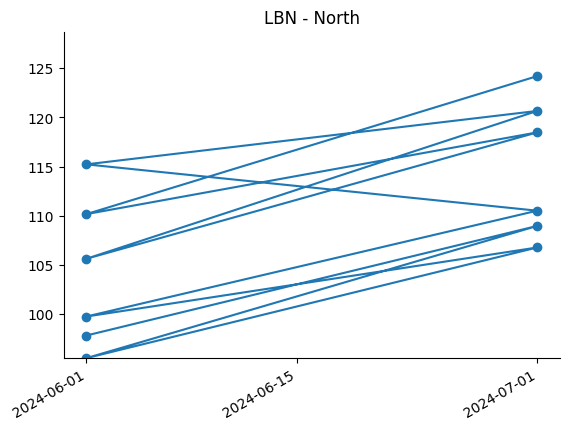

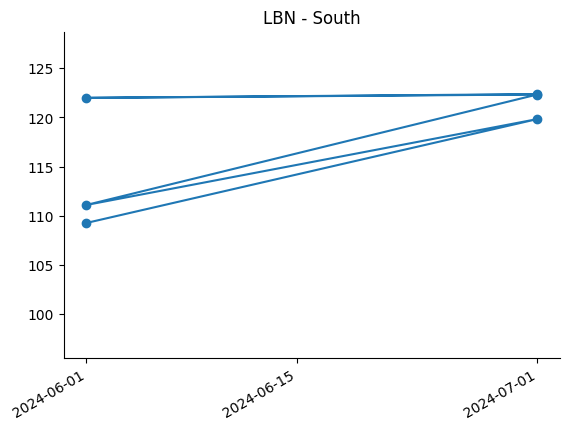

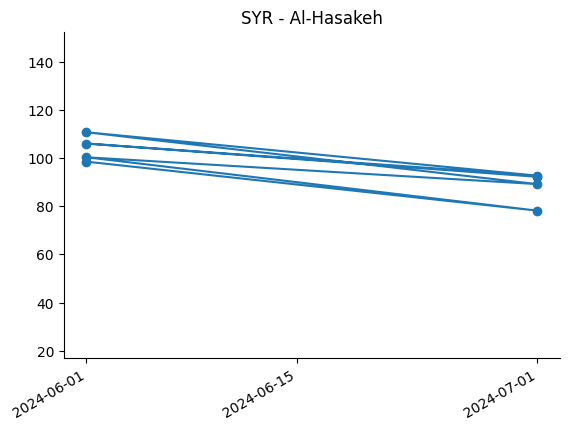

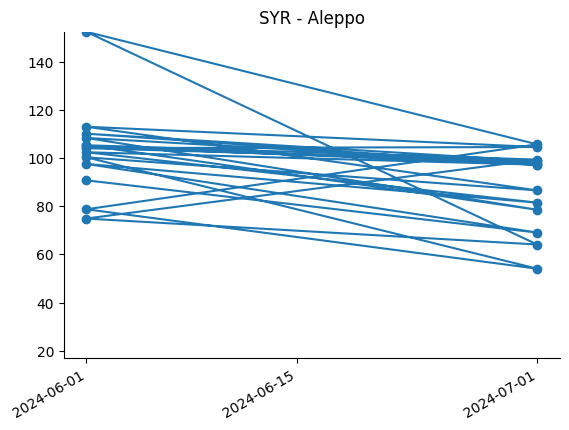

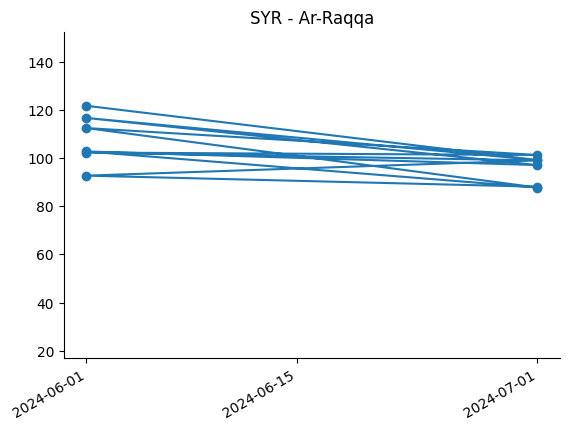

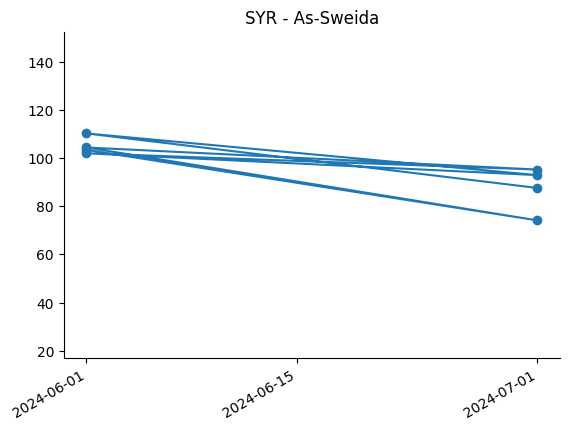

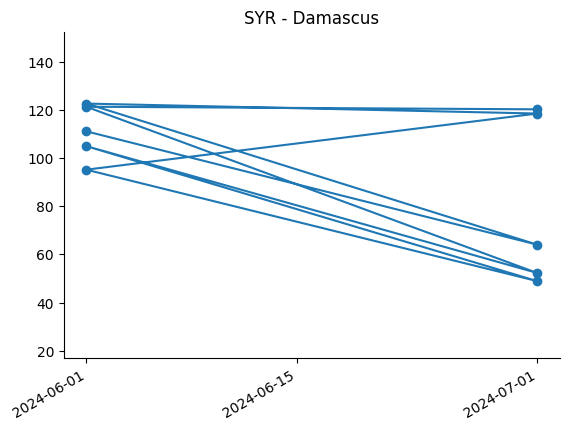

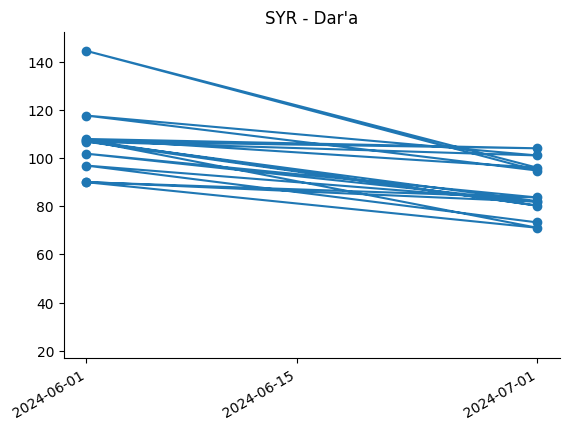

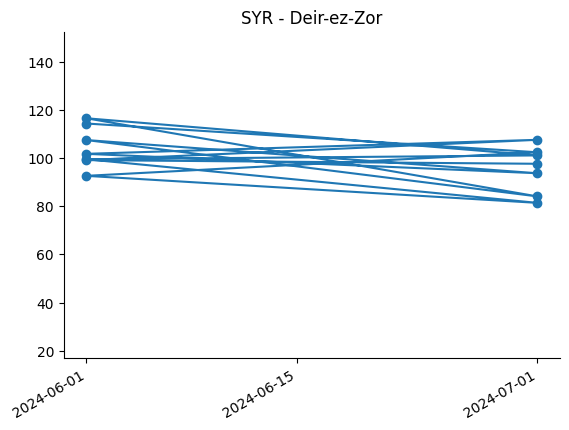

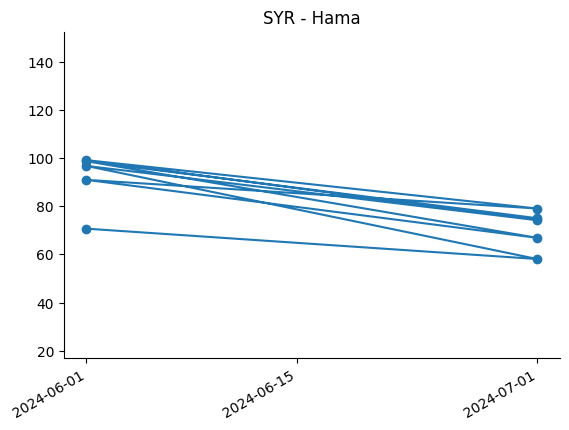

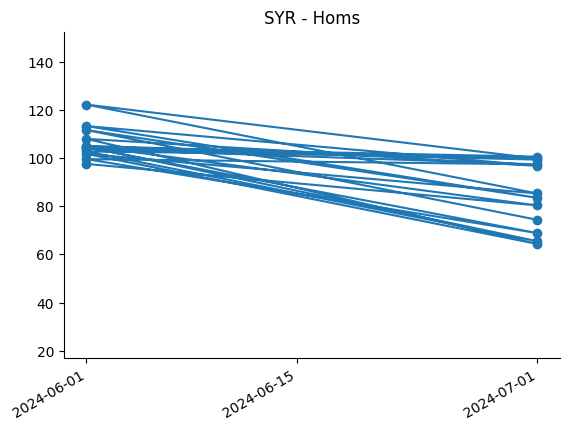

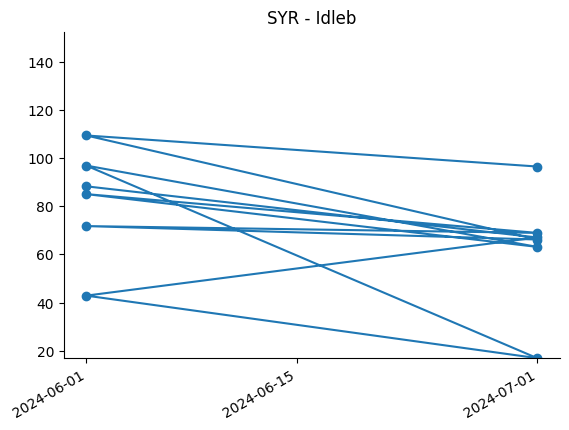

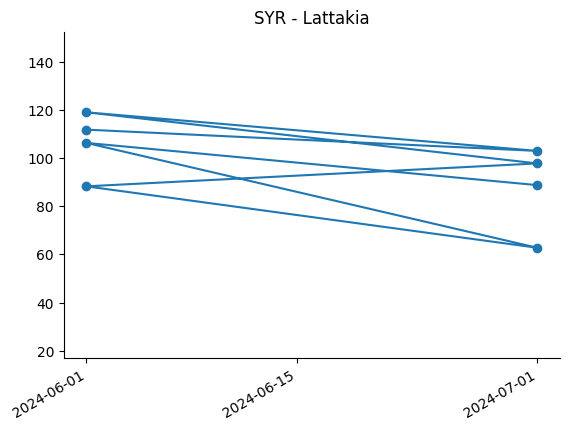

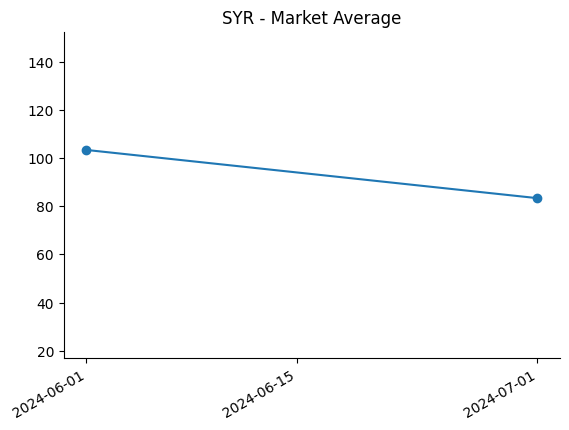

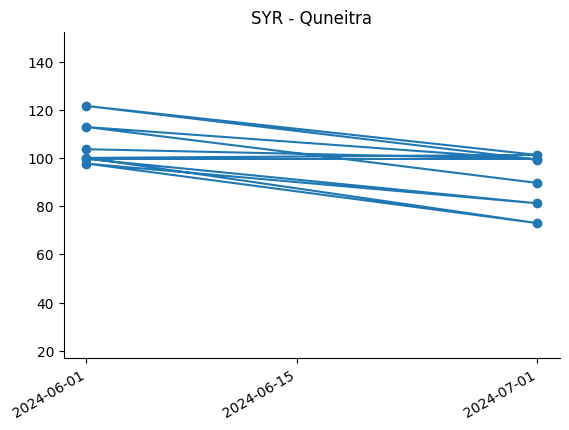

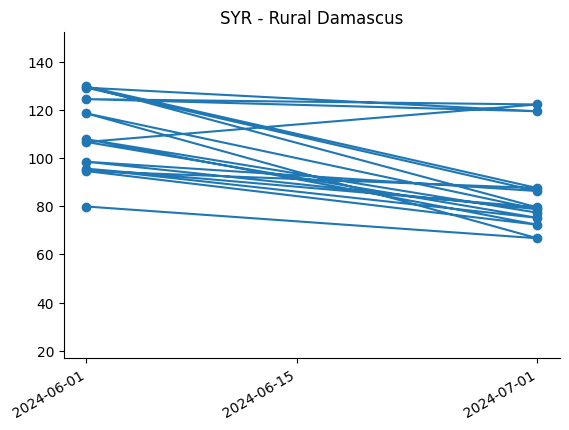

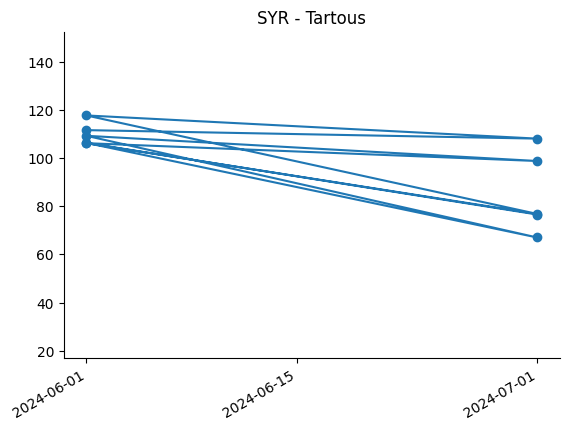

In [ ]:
for name, group in df.groupby(['ISO3', 'adm1_name']):
    # Calculate mean over dates
    mean_series = group.groupby(group.index)['inflation_food_price_index'].mean()
    ylim = ylim_dict[name[0]]
    ax = mean_series.plot(title='{:s} - {:s}'.format(name[0], name[1]), style='o-', ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(0, linestyle='--', color='grey')
    ax.legend().set_visible(False)
    ax.set_xlabel('')
    ax.set_xticks([pd.to_datetime('2024-06-01'), pd.to_datetime('2024-06-15'), pd.to_datetime('2024-07-01')])